In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
% matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

C:\Users\Michal_schudnij\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_warszawa = pd.read_csv("../datasets/preprocessed_data/df_warszawa.csv")
df_krakow = pd.read_csv("../datasets/preprocessed_data/df_krakow.csv")
df_poznan = pd.read_csv("../datasets/preprocessed_data/df_poznan.csv")

In [3]:
df = pd.concat([df_warszawa, df_krakow, df_poznan])
df = df.drop(columns = {'geometry'})
features = df.columns.to_list()
features.remove('grid_index')

In [4]:
df.head()

,grid_index,dhl,dpd,fedex,inpost,poczta,ruch,ups,tot,tot_0_14,...,buildings,shops,parks,forests,schools,railways,cycleways,parkings,crossings,bus_stops
0,206436,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4841,696,...,4.0,0.0,1.0,2.0,4.0,2.0,8.0,11.0,19.0,0.0
1,206464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,137,19,...,3.0,0.0,0.0,7.0,1.0,0.0,0.0,1.0,1.0,0.0
2,206476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,269,38,...,14.0,0.0,0.0,0.0,0.0,8.0,0.0,2.0,4.0,0.0
3,206492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
4,206505,0.0,0.0,0.0,0.0,1.0,0.0,0.0,386,63,...,0.0,0.0,0.0,8.0,0.0,0.0,4.0,3.0,1.0,0.0


In [5]:
df[features].describe()

,dhl,dpd,fedex,inpost,poczta,ruch,ups,tot,tot_0_14,tot_15_64,...,buildings,shops,parks,forests,schools,railways,cycleways,parkings,crossings,bus_stops
count,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,...,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000
mean,1.337623,0.336866,0.029523,1.295231,1.550341,0.325511,0.181681,2373.777441,311.791067,1674.764572,...,20.152157,0.214232,0.933384,8.904618,3.032551,8.556397,8.024981,17.895534,27.340651,0.411052
std,2.734103,0.775132,0.182260,2.016759,3.016483,0.791063,0.518153,3918.920701,479.119597,2756.580015,...,57.600955,0.898809,3.153178,9.817038,5.145578,19.914934,13.926380,35.462460,39.265884,1.717512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106.000000,17.000000,76.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,519.000000,87.000000,380.000000,...,2.000000,0.000000,0.000000,6.000000,1.000000,0.000000,1.000000,3.000000,9.000000,0.000000
75%,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,2459.000000,364.000000,1759.000000,...,12.000000,0.000000,1.000000,12.000000,4.000000,7.000000,11.000000,21.000000,39.000000,0.000000
max,28.000000,9.000000,2.000000,13.000000,27.000000,7.000000,5.000000,21531.000000,2672.000000,15020.000000,...,761.000000,15.000000,62.000000,68.000000,44.000000,178.000000,123.000000,337.000000,248.000000,15.000000


In [6]:
to_remove = []
for i in features:
    print("\n ############ \nFeature:", i)
    print(round(df[i].value_counts()[0]/df.shape[0]*100,2), f"% of grids with 0 {i}.")
    print(df[i].nunique(), "unique values.")
    
    if(round(df[i].value_counts()[0]/df.shape[0]*100,2)>90):
        to_remove.append(i)
        features.remove(i)


 ############ 
Feature: dhl
62.83 % of grids with 0 dhl.
18 unique values.

 ############ 
Feature: dpd
77.97 % of grids with 0 dpd.
8 unique values.

 ############ 
Feature: fedex
97.27 % of grids with 0 fedex.
3 unique values.

 ############ 
Feature: poczta
60.26 % of grids with 0 poczta.
23 unique values.

 ############ 
Feature: ruch
80.39 % of grids with 0 ruch.
8 unique values.

 ############ 
Feature: ups
86.0 % of grids with 0 ups.
6 unique values.

 ############ 
Feature: tot
7.57 % of grids with 0 tot.
939 unique values.

 ############ 
Feature: tot_0_14
11.13 % of grids with 0 tot_0_14.
557 unique values.

 ############ 
Feature: tot_15_64
7.87 % of grids with 0 tot_15_64.
882 unique values.

 ############ 
Feature: tot_65__
11.05 % of grids with 0 tot_65__.
526 unique values.

 ############ 
Feature: tot_male
8.1 % of grids with 0 tot_male.
788 unique values.

 ############ 
Feature: tot_fem
8.48 % of grids with 0 tot_fem.
800 unique values.

 ############ 
Feature: male_

In [7]:
# Variables to_remove
to_remove

['fedex', 'bus_stops']

In [8]:
df = df.drop(columns = to_remove)

In [9]:
df['tot'].value_counts()[:5] #.index.tolist()

0     100
3      11
4       8
15      7
6       7
Name: tot, dtype: int64

##############
dhl
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


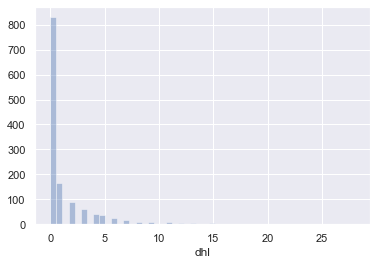

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


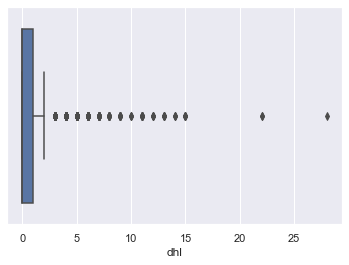

##############
dpd
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


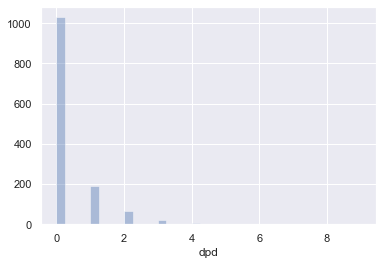

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


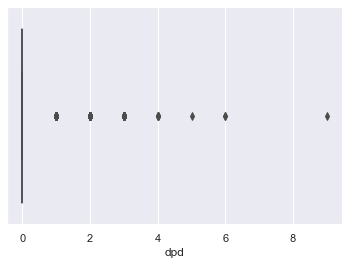

##############
inpost
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


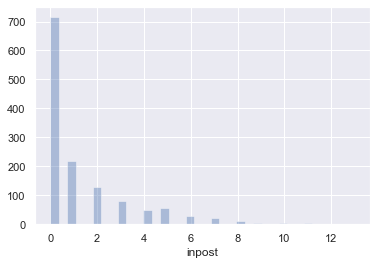

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


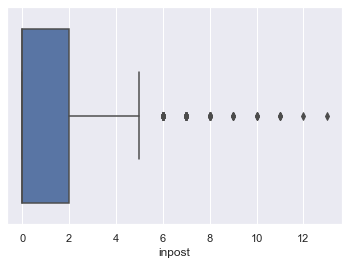

##############
poczta
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


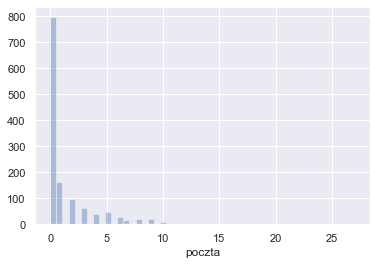

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


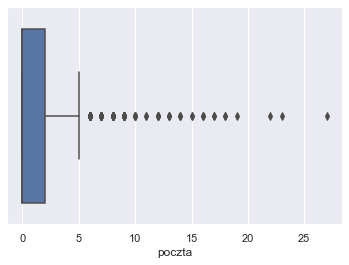

##############
ruch
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


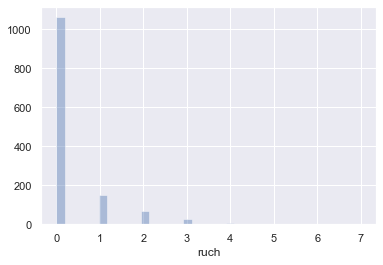

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


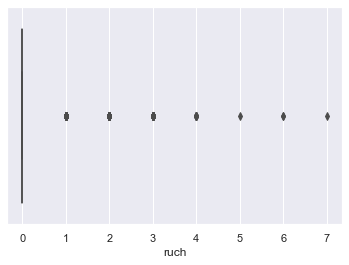

##############
ups
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


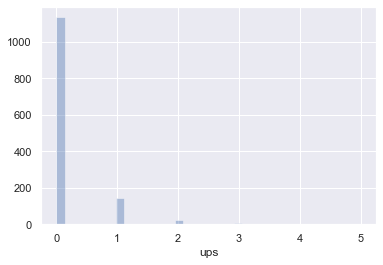

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


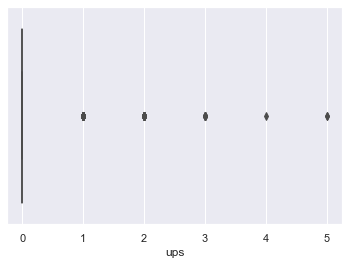

##############
tot
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


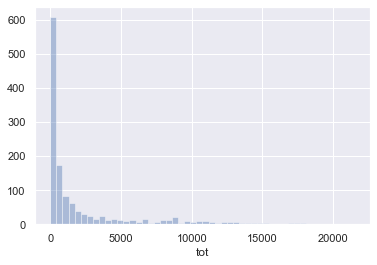

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


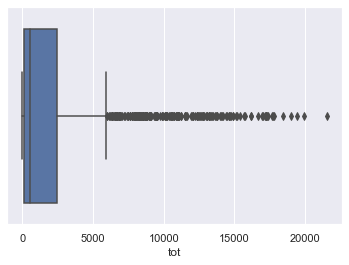

##############
tot_0_14
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


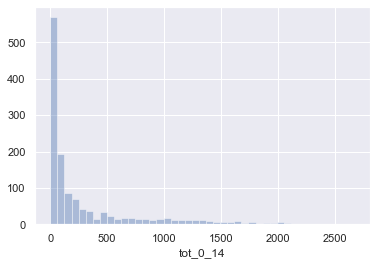

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


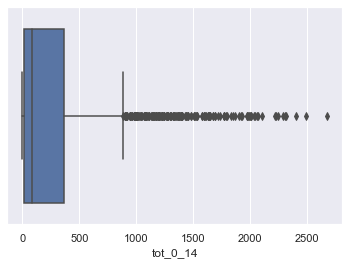

##############
tot_15_64
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


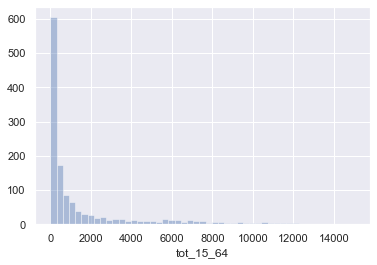

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


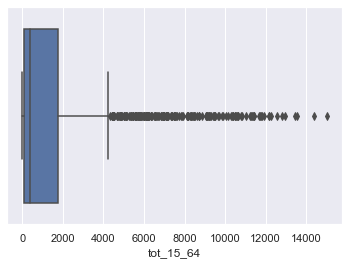

##############
tot_65__
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


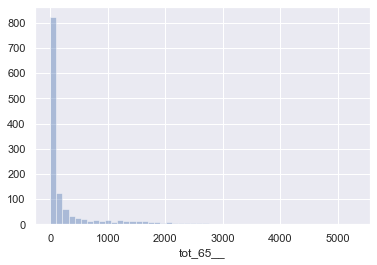

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


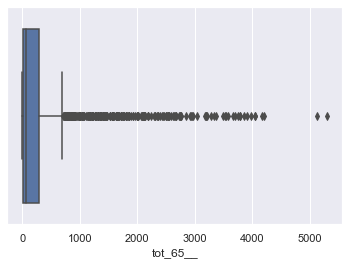

##############
tot_male
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


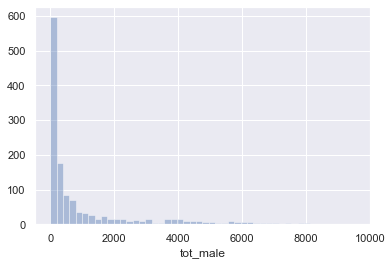

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


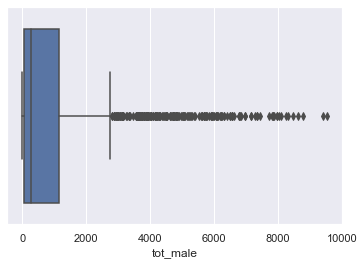

##############
tot_fem
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


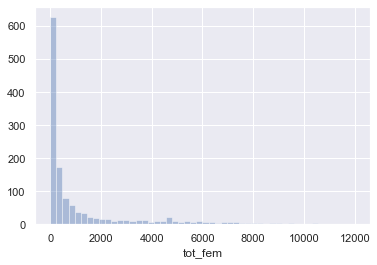

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


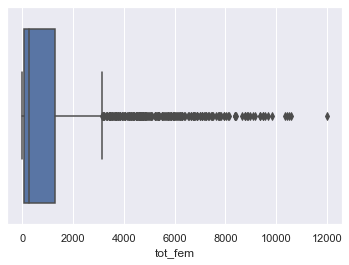

##############
male_0_14
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


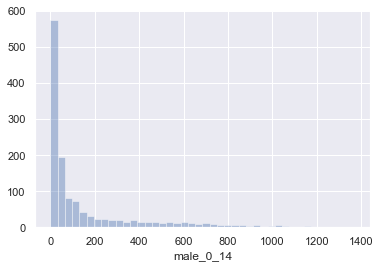

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


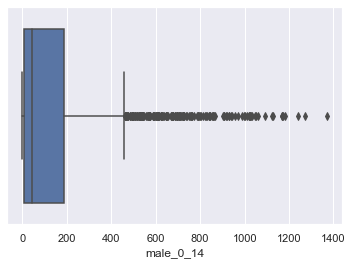

##############
male_15_64
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


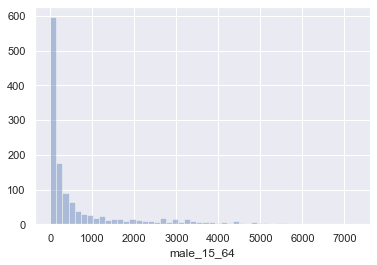

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


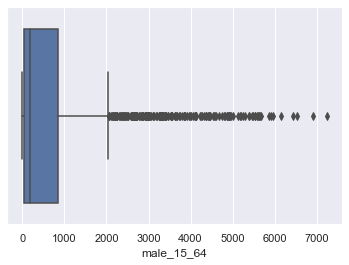

##############
male_65__
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


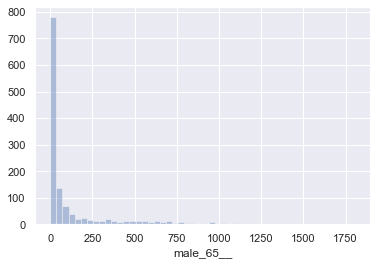

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


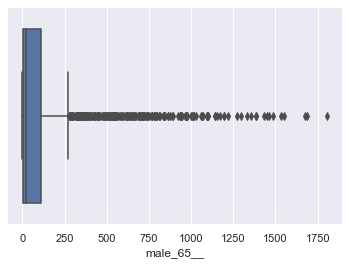

##############
fem_0_14
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


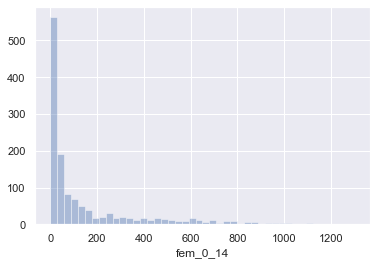

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


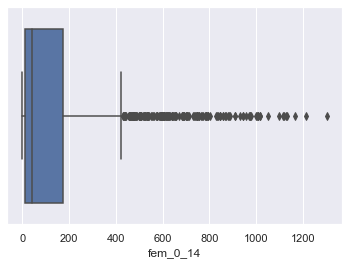

##############
fem_15_64
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


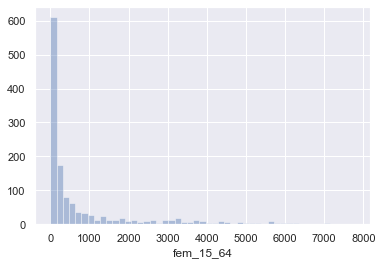

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


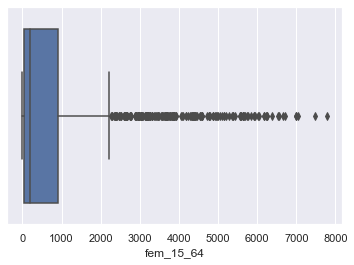

##############
fem_65__
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


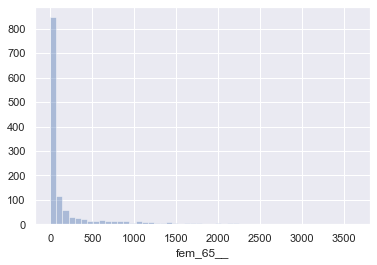

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


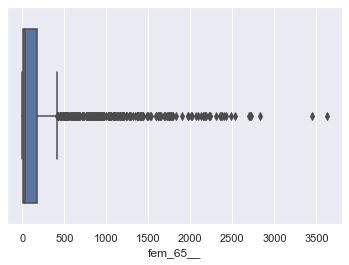

##############
fem_ratio
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


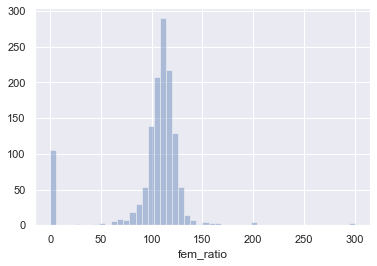

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


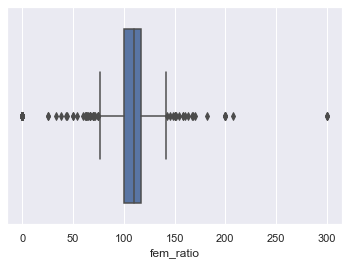

##############
buildings
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


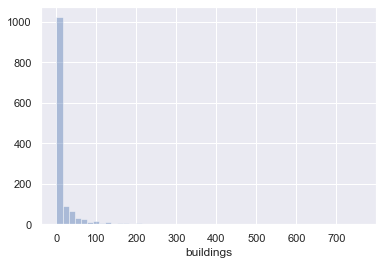

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


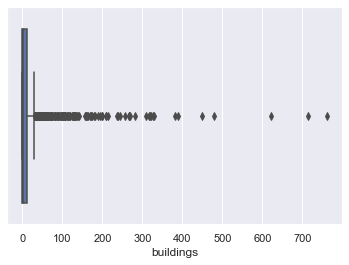

##############
shops
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


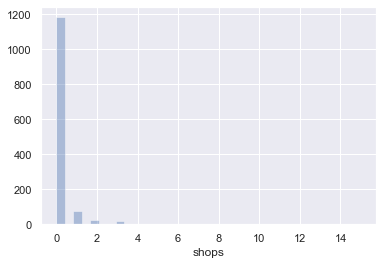

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


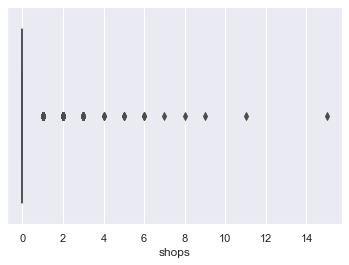

##############
parks
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


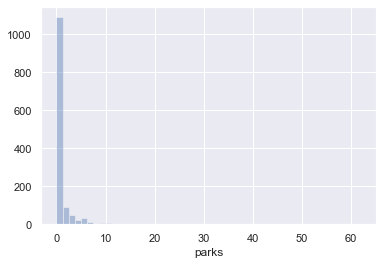

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


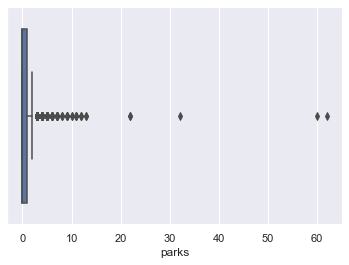

##############
forests
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


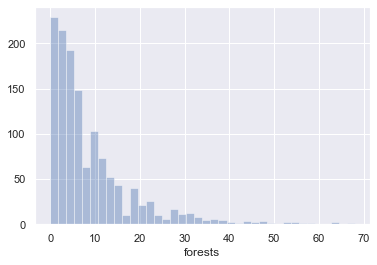

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


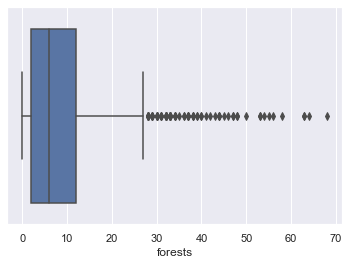

##############
schools
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


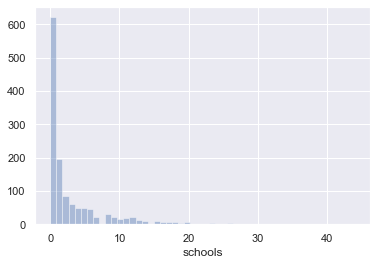

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


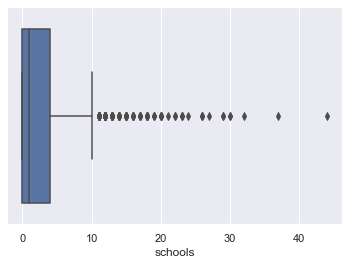

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


##############
railways
##############


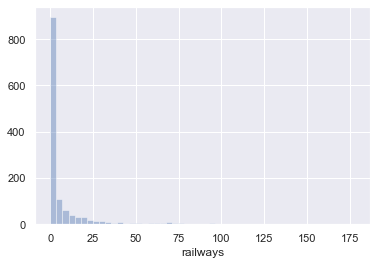

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


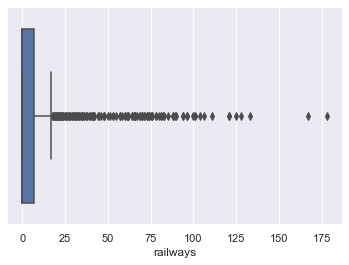

##############
cycleways
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


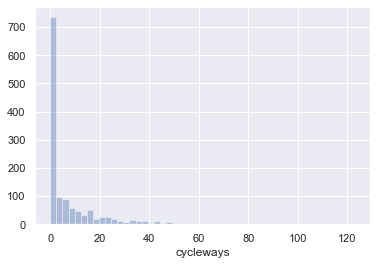

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


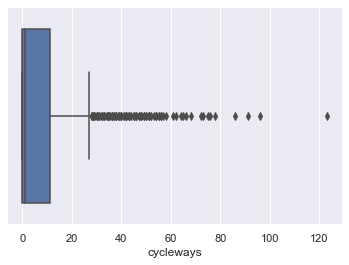

##############
parkings
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


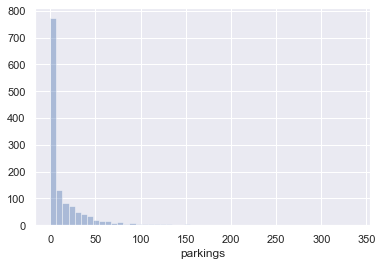

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


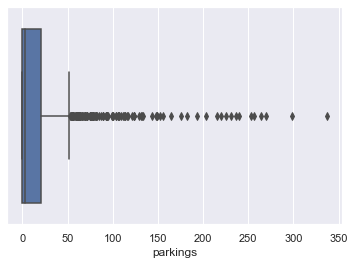

##############
crossings
##############


c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


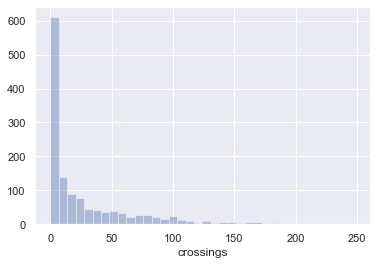

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


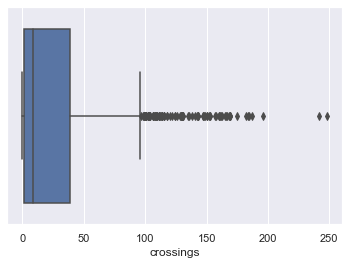

In [10]:
for i in features:
    print(f"##############\n{i}\n##############")
    sns.distplot(df[i], kde=False)
    plt.plot()
    plt.show()
    sns.boxplot(df[i])
    plt.plot()
    plt.show()

### Correlation

In [11]:
# Creating a matrix using age, salry, balance as rows and columns
df[features].corr()

,dhl,dpd,inpost,poczta,ruch,ups,tot,tot_0_14,tot_15_64,tot_65__,...,fem_ratio,buildings,shops,parks,forests,schools,railways,cycleways,parkings,crossings
dhl,1.000000,0.619046,0.699638,0.939009,0.636024,0.537411,0.699248,0.668117,0.701276,0.639243,...,0.206739,0.139584,0.444369,0.343915,-0.074583,0.561940,0.301946,0.553573,0.568159,0.772155
dpd,0.619046,1.000000,0.575054,0.655815,0.573450,0.449208,0.620209,0.598663,0.620735,0.567779,...,0.173452,0.134321,0.344339,0.330304,-0.058495,0.502869,0.150831,0.364716,0.421215,0.594373
inpost,0.699638,0.575054,1.000000,0.700024,0.627307,0.524976,0.771294,0.762923,0.770340,0.700319,...,0.243415,0.178293,0.365460,0.270901,-0.076100,0.654709,0.200638,0.523073,0.571013,0.710435
poczta,0.939009,0.655815,0.700024,1.000000,0.719836,0.568991,0.768687,0.725682,0.767171,0.721797,...,0.216418,0.167669,0.435687,0.371833,-0.095133,0.604113,0.285252,0.549090,0.602133,0.796831
ruch,0.636024,0.573450,0.627307,0.719836,1.000000,0.550547,0.718894,0.663610,0.709592,0.713038,...,0.180829,0.172620,0.388775,0.381966,-0.055993,0.564673,0.132230,0.379471,0.481067,0.660451
ups,0.537411,0.449208,0.524976,0.568991,0.550547,1.000000,0.544252,0.508537,0.544616,0.509166,...,0.147835,0.101873,0.274232,0.319935,-0.036356,0.429106,0.096282,0.338054,0.345376,0.504359
tot,0.699248,0.620209,0.771294,0.768687,0.718894,0.544252,1.000000,0.962392,0.997297,0.930113,...,0.253931,0.213281,0.438120,0.368495,-0.070092,0.808090,0.168436,0.532937,0.641840,0.768806
tot_0_14,0.668117,0.598663,0.762923,0.725682,0.663610,0.508537,0.962392,1.000000,0.967492,0.820862,...,0.252999,0.221607,0.388202,0.330779,-0.059249,0.807373,0.141103,0.499685,0.632116,0.728696
tot_15_64,0.701276,0.620735,0.770340,0.767171,0.709592,0.544616,0.997297,0.967492,1.000000,0.903223,...,0.250103,0.213240,0.436175,0.361880,-0.068489,0.810377,0.168712,0.528717,0.650686,0.763605
tot_65__,0.639243,0.567779,0.700319,0.721797,0.713038,0.509166,0.930113,0.820862,0.903223,1.000000,...,0.242108,0.186161,0.431279,0.378077,-0.075472,0.716779,0.167218,0.514050,0.549641,0.733414


In [12]:
plt.rcParams["figure.figsize"] = (20, 16)

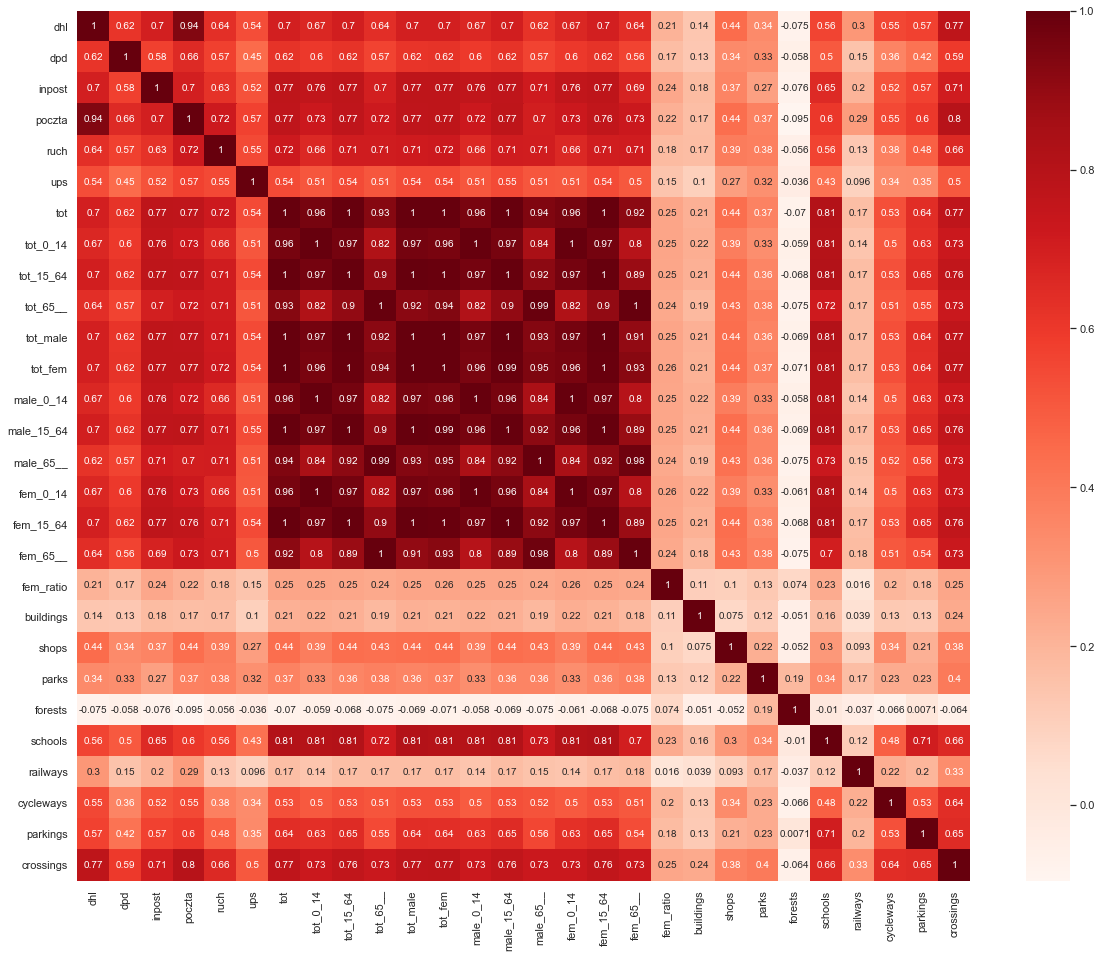

In [13]:
sns.heatmap(df[features].corr(), annot=True, cmap = 'Reds')
plt.show()

In [14]:
operators = ['dhl','dpd','inpost','poczta','ruch','ups']
demo = ['tot','tot_0_14','tot_15_64','tot_65__','tot_male','tot_fem','male_0_14','male_15_64','male_65__','fem_0_14','fem_15_64','fem_65__','fem_ratio']
points = ['buildings','shops','parks','forests','schools','railways','cycleways','parkings','crossings']

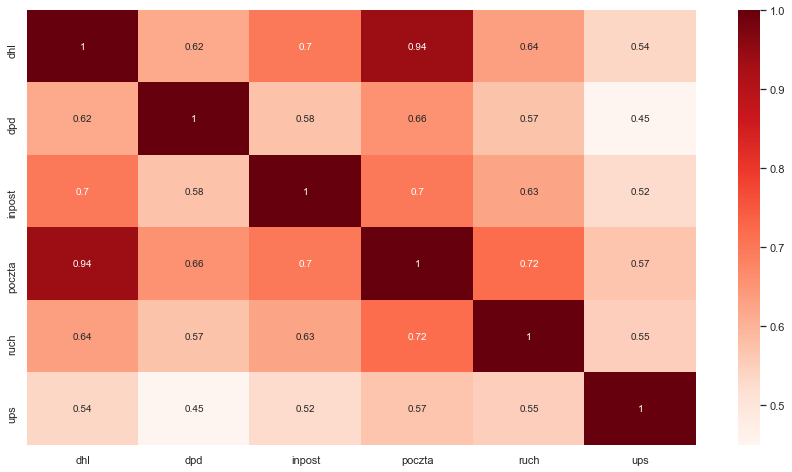

In [15]:
plt.rcParams["figure.figsize"] = (15, 8)
sns.heatmap(df[operators].corr(), annot=True, cmap = 'Reds')
plt.show()

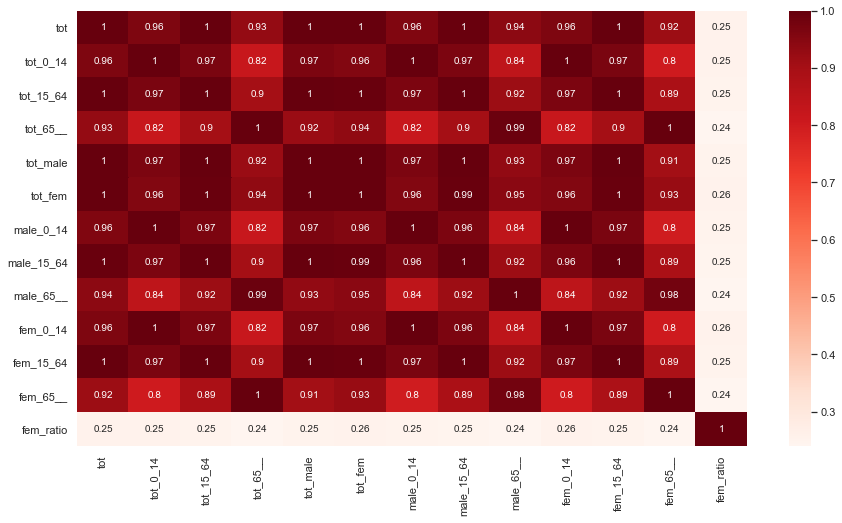

In [16]:
plt.rcParams["figure.figsize"] = (15, 8)
sns.heatmap(df[demo].corr(), annot=True, cmap = 'Reds')
plt.show()

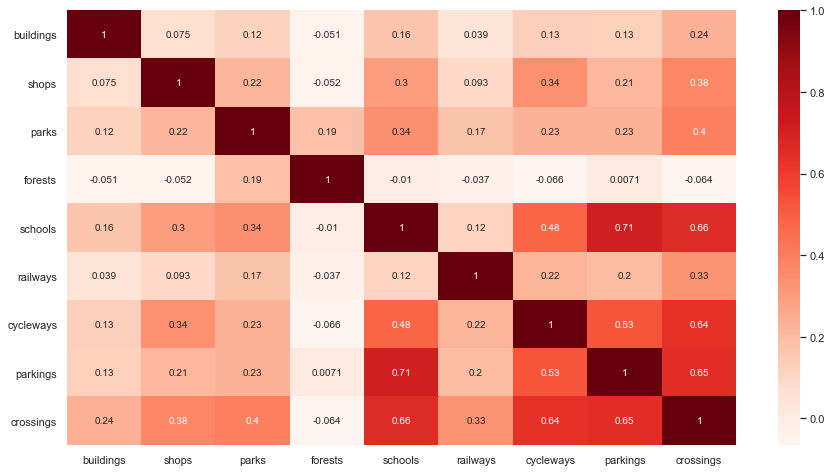

In [17]:
plt.rcParams["figure.figsize"] = (15, 8)
sns.heatmap(df[points].corr(), annot=True, cmap = 'Reds')
plt.show()

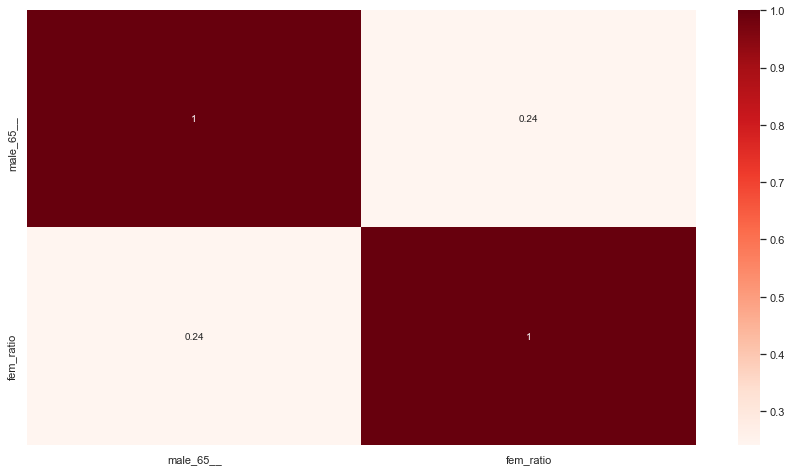

In [18]:
plt.rcParams["figure.figsize"] = (15, 8)
sns.heatmap(df[['male_65__', 'fem_ratio']].corr(), annot=True, cmap = 'Reds')
plt.show()

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


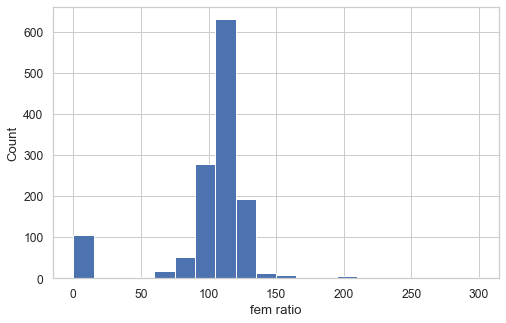

In [19]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    df['fem_ratio'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='fem ratio', ylabel='Count');

In [96]:
len(features)

28

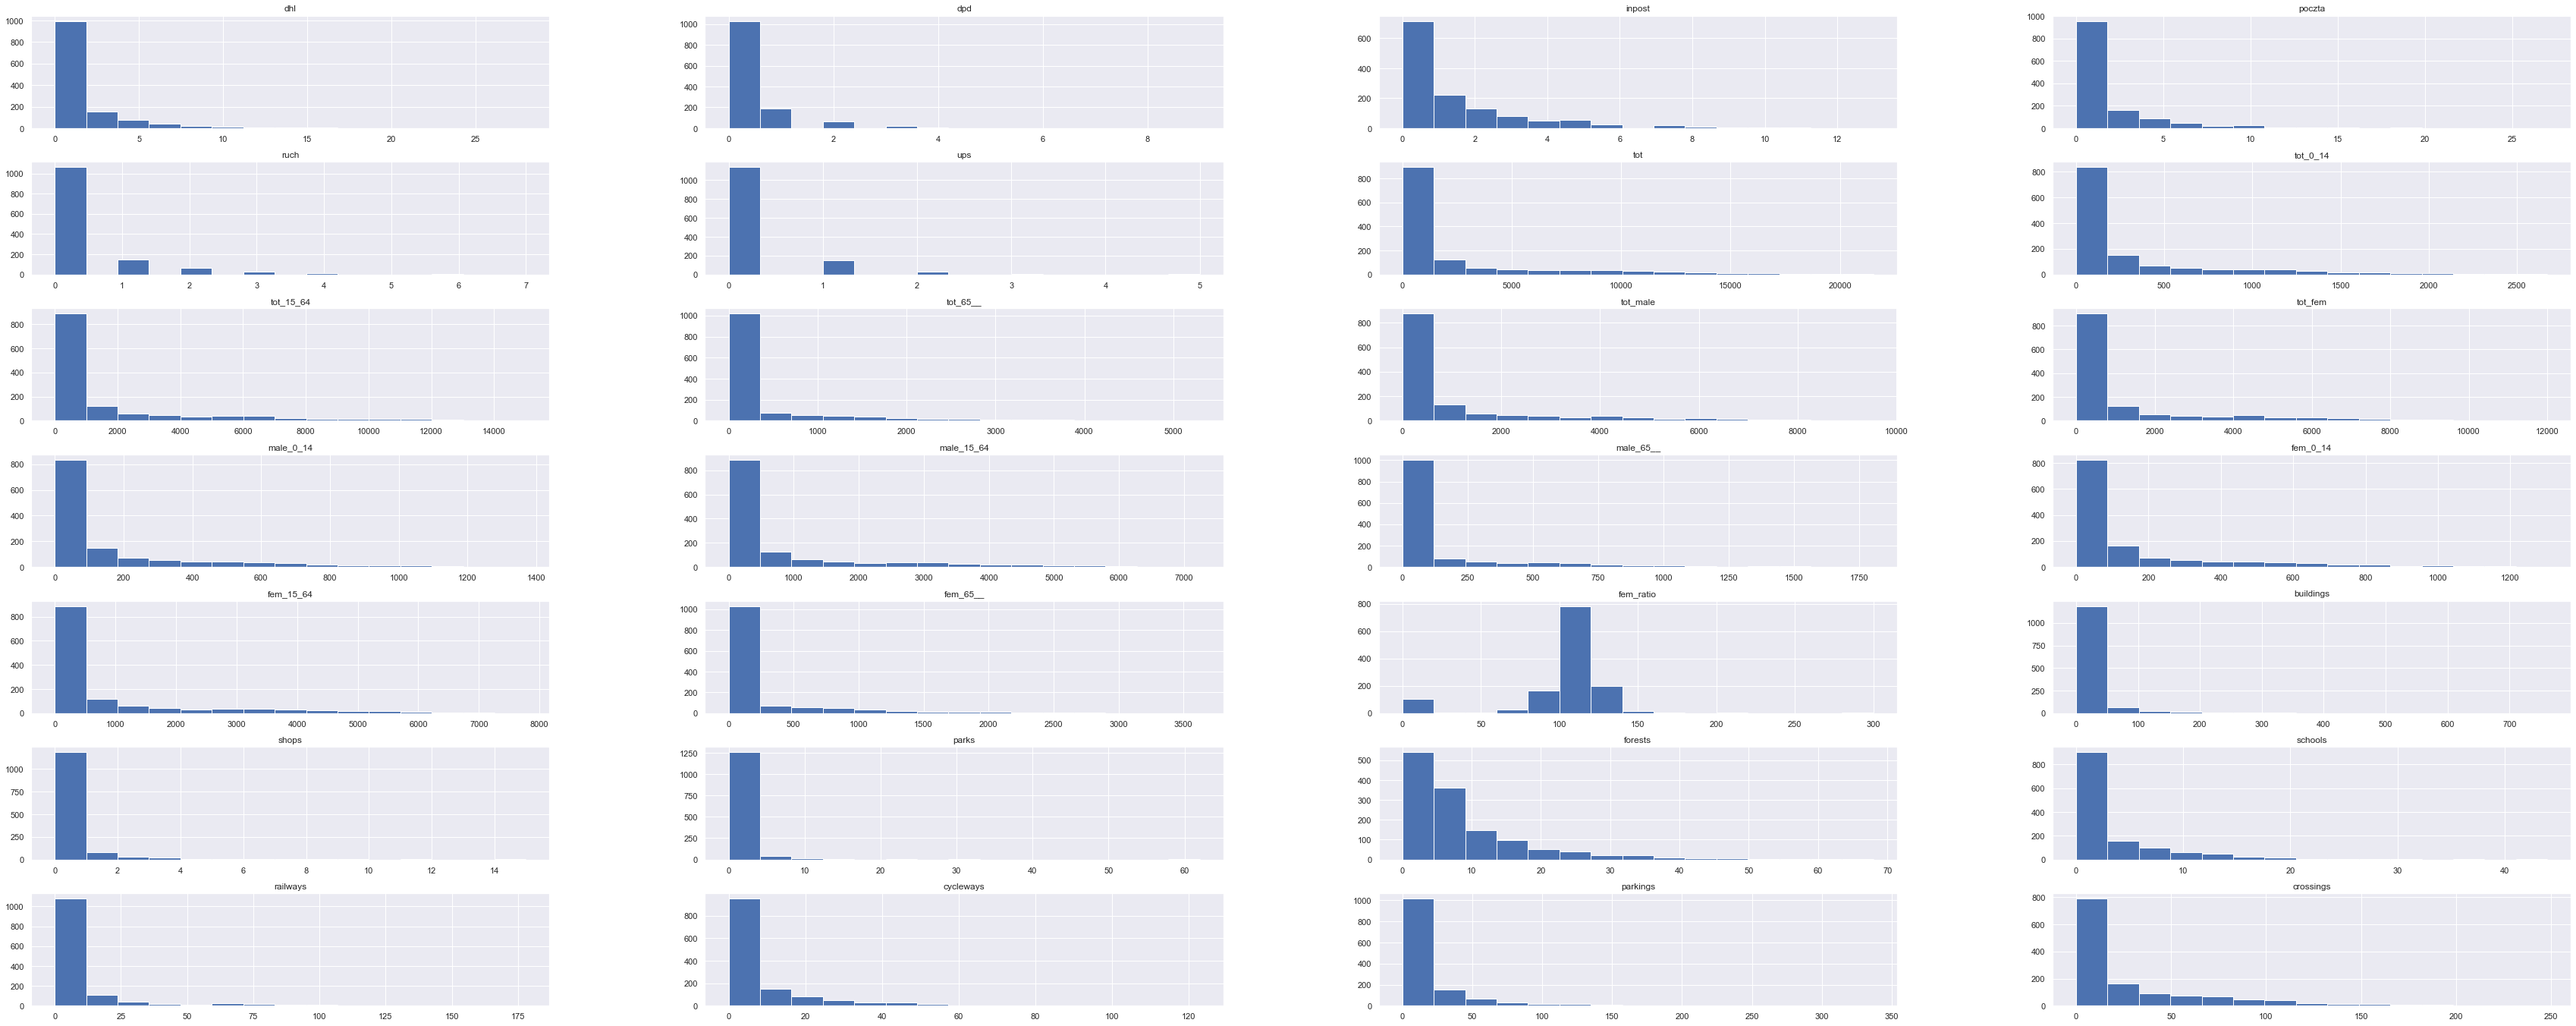

In [107]:
plt.rcParams["figure.figsize"] = (60, 24)
df[features].hist(bins=15, layout=(7, 4));

In [115]:
sns.set(style='darkgrid')
def wizualizacje(x):
    plt.figure(figsize=(10, 5))
    sns.distplot(x, kde=False, bins=10, color = 'indianred', hist = True)
    plt.plot()

c:\users\michal_schudnij\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


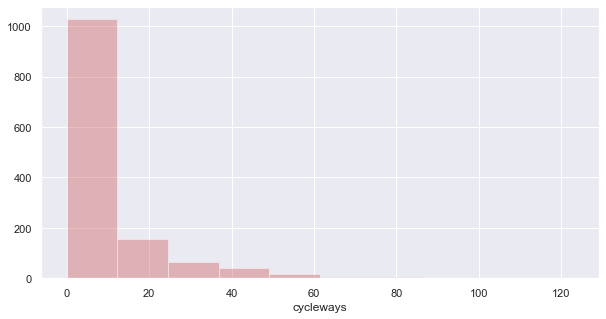

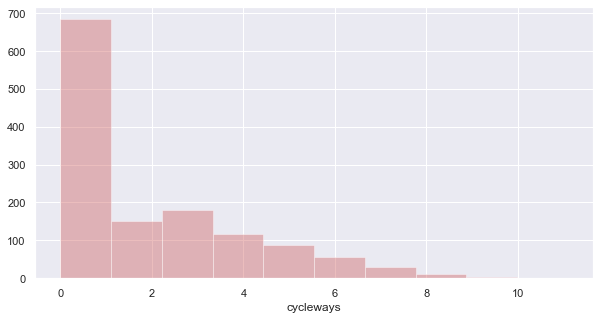

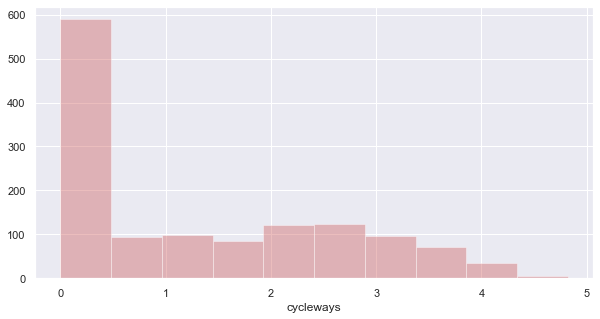

In [120]:
wizualizacje(df['cycleways'])
wizualizacje(np.sqrt(df['cycleways']))
wizualizacje(np.log(1+df['cycleways']))